# Neural Networks

In [214]:
from pathlib import Path
import pandas as pd
import numpy as np
import pandas_profiling
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)
from sklearn.preprocessing import MinMaxScaler

from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN
from tensorflow.keras import regularizers
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import model_from_json
from keras.optimizers import Adam

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [6]:
import joblib

In [163]:
### Loading up Variables:
def get_unsplit_data(city):
    return joblib.load("data/full_splits/{}.joblib".format( city))

def idx2CityName(idx):
    mapping = {0 : 'Aotizhongxin', 
     1 : 'Changping',
     2 : 'Dingling',
     3 : 'Dongsi',
     4 : 'Guanyuan',
     5 : 'Gucheng',
     6 : 'Huairou',
     7 : 'Nongzhanguan',
     8 : 'Shunyi',
     9 : 'Tiantan',
     10 : 'Wanliu',
     11 : 'Wanshouxigong'}
    
    return mapping[idx]

def cityName2Idx(cityName):
    mapping = {'Aotizhongxin' : 0, 
     'Changping' : 1,
     'Dingling' : 2,
     'Dongsi' : 3,
     'Guanyuan' : 4,
     'Gucheng' : 5,
     'Huairou' : 6,
     'Nongzhanguan' : 7,
     'Shunyi' : 8,
     'Tiantan' : 9,
     'Wanliu' : 10,
     'Wanshouxigong' : 11}
    
    return mapping[cityName]

def split(df, resp_col):
    cols = df.columns
    pred_cols = [pred_col for pred_col in cols if pred_col is not resp_col]
    X = df[pred_cols]
    y = df[resp_col]
    return X, y

def perform_grid_search_cross_validation(model, X_train, y_train, grid_param, scoring='accuracy', cv=5, n_jobs=1):
    gd_sr = GridSearchCV(estimator=model, param_grid=grid_param, scoring=scoring, cv=cv, n_jobs=n_jobs)
    gd_sr.fit(X_train, y_train)
    return gd_sr.best_params_
    

def validate_prediction(y, y_pred):
    mse = mean_squared_error(y, y_pred)
    mae = mean_absolute_error(y, y_pred)

    return "mse = {mse} & mae = {mae} & rmse = {rmse}".format(mse=mse, mae=mae, rmse=sqrt(mse))


def create_feed(X, y):
    seqs = []
    cols = X.columns
    for col in cols:
        seq = X[col].values.astype('float32')
        seq = seq.reshape((len(seq), 1))
        seqs.append(seq)
    seq = y.values.astype('float32')
    seq = seq.reshape((len(seq), 1))
    seqs.append(seq)
        
    return (np.hstack(tuple(seqs)), seq)

## Simple Recurrent NN for Univariate Forcasting

In [88]:
dfs = []
for idx in range(0,12):
    df = get_unsplit_data(idx2CityName(idx))
    df.set_index(['timestamp'], inplace=True)
    dfs.append(df)

In [178]:
# DF == Wanshouxigong
train = df.query('timestamp < "2015-07-01"')
valid = df.query('timestamp >= "2015-07-01" and timestamp < "2016-05-01"')
test = df.query('timestamp >= "2016-05-01"')

cols = train.columns
train_idx = train.index
valid_idx = valid.index
test_idx = test.index

train = pd.DataFrame(train, columns=cols, index=train_idx)
valid = pd.DataFrame(valid, columns=cols, index=valid_idx)
test = pd.DataFrame(test, columns=cols, index=test_idx)

In [179]:
train_y= train[['SO2']]
valid_y = valid[['SO2']]
test_y = test[['SO2']]

wd_dummies = pd.get_dummies(train['wd'])
train.drop(['wd', 'station', 'SO2'], inplace=True, axis=1)
train = pd.concat([train, wd_dummies],axis=1)

wd_dummies = pd.get_dummies(valid['wd'])
valid.drop(['wd', 'station', 'SO2'], inplace=True, axis=1)
valid = pd.concat([valid, wd_dummies], axis=1)

wd_dummies = pd.get_dummies(test['wd'])
test.drop(['wd', 'station', 'SO2'], inplace=True, axis=1)
test = pd.concat([test, wd_dummies], axis=1)

In [180]:
train_feed, train_feed_y = create_feed(train, train_y)
valid_feed, valid_feed_y = create_feed(valid, valid_y)
test_feed, test_feed_y = create_feed(test, test_y)

### Univariate Forcasting:  SO2

In [196]:
def plot_loss(history, title):
    plt.figure(figsize=(10,6))
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title(title)
    plt.xlabel('Nb Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    val_loss = history.history['val_loss']
    min_idx = np.argmin(val_loss)
    min_val_loss = val_loss[min_idx]
    print('Minimum validation loss of {} reached at epoch {}'.format(min_val_loss, min_idx))
    
def plot_accuracy(history, title):
    plt.figure(figsize=(10,6))
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title(title)
    plt.xlabel('Nb Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    #['accuracy', 'loss', 'val_accuracy', 'val_loss']
    
    val_loss = history.history['val_accuracy']
    min_idx = np.argmin(val_loss)
    min_val_loss = val_loss[min_idx]
    print('Minimum validation loss of {} reached at epoch {}'.format(min_val_loss, min_idx))

In [220]:
n_features = train_feed.shape[1]
n_lag = 10 ##Observations 15 days prior -> predict current
train_data_gen = TimeseriesGenerator(train_feed, train_feed_y, length=n_lag, sampling_rate=1, stride=1, batch_size = 5)
valid_data_gen = TimeseriesGenerator(valid_feed, valid_feed_y, length=n_lag, sampling_rate=1, stride=1, batch_size = 1)
test_data_gen = TimeseriesGenerator(test_feed, test_feed_y, length=n_lag, sampling_rate=1, stride=1, batch_size = 1)

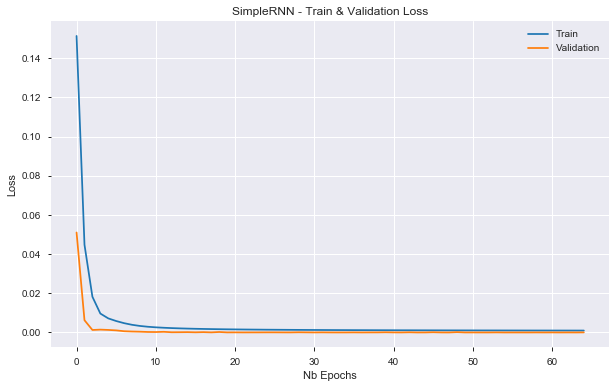

Minimum validation loss of 4.1848870750982314e-06 reached at epoch 54


In [221]:
REGULARIZATION_RATE = 0.01
simple_rnn = Sequential()
simple_rnn.add(SimpleRNN(4, input_shape=(n_lag, n_features), 
                         activity_regularizer=regularizers.l1_l2(REGULARIZATION_RATE, REGULARIZATION_RATE)))
simple_rnn.add(Dense(1))
adam = Adam(lr=0.0001)
simple_rnn.compile(loss='mse', optimizer=adam)

checkpointer = ModelCheckpoint(filepath='data/model/simple_rnn_weights.hdf5'
                               , verbose=0
                               , save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss'
                             , patience=10
                             , verbose=0)
with open("data/model/simple_rnn.json", "w") as m:
    m.write(simple_rnn.to_json())

simple_rnn_history = simple_rnn.fit_generator(train_data_gen
                                              , epochs=100
                                              , validation_data=valid_data_gen
                                              , verbose=0
                                              , callbacks=[checkpointer, earlystopper])
plot_loss(simple_rnn_history, 'SimpleRNN - Train & Validation Loss')

In [202]:
y_pred = simple_rnn.predict_generator(test_data_gen)

In [203]:
d = test_y.values.astype('float32')

In [207]:
validate_prediction(d, y_pred)

ValueError: Found input variables with inconsistent numbers of samples: [7296, 7281]

In [198]:
def eval_best_model(model):
    # Load model architecture from JSON
    model_architecture = open('data/model/'+model+'.json', 'r')
    best_model = model_from_json(model_architecture.read())
    model_architecture.close()
    # Load best model's weights
    best_model.load_weights('data/model/'+model+'_weights.hdf5')
    # Compile the best model
    best_model.compile(loss='mae', optimizer=RMSprop())
    # Evaluate on test data
    perf_best_model = best_model.evaluate_generator(test_data_gen)
    print('Loss on test data for {} : {}'.format(model, perf_best_model))

eval_best_model('simple_rnn')

Loss on test data for simple_rnn : 0.00402029138058424
